# Influencia del alcoholismo en los adolescentes en su rendimiento académico

Este proyecto de aprendizaje automático se basa en un conjunto de datos que proporciona una visión detallada de los factores socioeducativos que influyen en el comportamiento de los estudiantes, con un enfoque particular en el consumo de alcohol y el rendimiento académico. Los datos, recopilados a través de una encuesta realizada entre estudiantes de secundaria, ofrecen una oportunidad única para explorar la interacción entre el comportamiento social, el consumo de alcohol y el rendimiento académico.

## Problema a Resolver

El objetivo principal de este proyecto es desarrollar un modelo de aprendizaje automático que pueda predecir el rendimiento académico de los estudiantes en función de una serie de características socioeducativas y de comportamiento. En particular, estamos interesados en entender cómo el consumo de alcohol puede afectar el rendimiento académico de los estudiantes. Este conocimiento podría ser invaluable para los educadores y los responsables de las políticas educativas para desarrollar intervenciones más efectivas y políticas de apoyo para los estudiantes.

## Explicación del Conjunto de Datos

El conjunto de datos consta de varias características que describen el entorno socioeducativo y el comportamiento de los estudiantes. Estas características incluyen información demográfica (como el sexo y la edad del estudiante), información sobre el entorno familiar y escolar (como el tamaño de la familia, el estado de convivencia de los padres, el tiempo de viaje a la escuela), información sobre el comportamiento del estudiante (como el tiempo de estudio, las actividades extraescolares, el consumo de alcohol) y las calificaciones académicas. 

Las calificaciones académicas se proporcionan para dos semestres ('G1' y 'G2'), y también se calcula una calificación media de estos dos semestres ('Media_G1_G2'). Además, se proporciona una calificación categórica ('Calificacion') que indica si el estudiante ha aprobado o no, basándose en la media del curso. Estos dos últimos atributos no son del dataset original, si no que son añadidos que emplearemos para afrontar los distintos modelos.

Detalles de atributos:

1. Escuela: Escuela del estudiante (binario: GP (Gabriel Pereira) o MS (Mousinho da Silveira))

2. Sexo: Sexo del estudiante (binario: 'F' - femenino o 'M' - masculino)

3. Edad: Edad del estudiante (numérica: 15 a 22)

4. Dirección: Tipo de dirección residencial del estudiante (binario: 'U' - urbano o 'R' - rural)

5. Famsize: Tamaño de la familia (binario: 'LE3' - menor o igual a 3 o 'GT3' - mayor que 3)

6. Estado: Padres' estado de convivencia (binario: 'T' - viviendo juntos o 'A' - separados)

7. Medu: Nivel educativo de la madre (0 - ninguno, 1 - Primaria 1, 2 - Primaria 2, 3 - Secundaria o 4 - Educación Superior)

8. Fedu: Nivel educativo del padre (0 - ninguno, 1 - Primaria 1, 2 - Primaria 2, 3 - Secundaria o 4 - Educación Superior)

9. Mjob:Trabajo de la madre (nominal: maestra, salud, servicios, en_casa u Otro)

10. Fjob:Trabajo del padre (nominal: maestro, salud, servicios, en_casa u Otro)

11. Razón: Razón para elegir esta escuela (nominal: hogar, reputación, curso u otro)

12. Tutor:Tutor del estudiante (nominal: madre, padre u otro)

13. Tiempo de viaje: Tiempo de viaje desde casa a la escuela (intervalos de tiempo: 1 - <15 min., 2 - 15 a 30 min., 3 - 30 min. a 1 hora o 4 - >1 hora)

14. Tiempo de estudio: Tiempo de estudio semanal (intervalos de tiempo: 1 - <2 horas, 2 - 2 a 5 horas, 3 - 5 a 10 horas o 4 - >10 horas )

15. Schoolsup: Apoyo educativo adicional (binario: sí o no)

16. Famsup:Apoyo educativo familiar (binario: sí o no)

17. Pagadas:Clases privadas sobre temas relacionados con el curso (binario: sí o no)

18. Actividades: Realiza actividades extraescolares (binario: sí o no)

19. Guardería: Asistió a guardería (binario: sí o no)

20. Mayor:Deseo de obtener una carrera (binario: sí o no)

21. Internet: Acceso a Internet en casa (binario: sí o no)

22. Romántico: ¿Estás en una relación romántica (binario: sí o no)

23. Famrel: Calidad de las relaciones familiares (categóricas: de 1 - muy mala a 5 - excelente)

24. Tiempo libre:Tiempo libre después de la escuela (categórico: de 1 - muy bajo a 5 - muy alto)

25. Salida: Tiempo con amigos (categórico: de 1 - muy bajo a 5 - muy alto)

26. Dalc: Consumo de alcohol en la jornada laboral (categórico: de 1 - muy bajo a 5 - muy alto)

27. Walc: Consumo de alcohol durante el fin de semana (categórico: de 1 - muy bajo a 5 - muy alto)

28. Salud: Estado de salud actual (categórico: de 1 - muy malo a 5 - muy bueno)

29. Ausencias: Número de ausencias escolares (numérico: de 0 a 93)

30. **G1:Calificación del primer semestre (numérica: de 0 a 20)**

31. **G2:Calificación del segundo semestre (numérica: de 0 a 20)**

32. **Media_G1_G2: Media aritmetica de las notas de los dos semestres**

33. **Calificacion: Si el alumno tiene aprobado el curso o suspenso (binario: 'aporbado' o 'suspenso')**

El atributo school diferencia únicamente entre 2 institutos de EEUU, lo cual no aporta informacion relevante por lo cual se descarta de los conjuntos usados para los modelos. Una vez impresos los pesos de los modelos se observo que este atributo era practicamente el único a traves del cual el modelo evaluava, por lo cual estaba creando un fuerte sesgo. Este es el principal motivo por el cual se ha decidido eliminar, ademas del resto de motivos mencionados.

In [208]:
#Librerias usadas en el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style('darkgrid')

import warnings

warnings.filterwarnings("ignore")

In [209]:
# Definimos una función para asignar las categorías
def asignar_categoria(media):
    if media < 10:
        return "suspenso"
    else:
        return "aprobado"

In [210]:
def conteo_clases(df):
    # Contamos el número de 'aprobados' y 'suspensos'
    num_aprobados = sum(df['Calificacion'] == 'aprobado')
    num_suspensos = sum(df['Calificacion'] == 'suspenso')

    # Etiquetas para el eje x
    labels = [f'Aprobados {num_aprobados}', f'Suspensos {num_suspensos}']

    # Valores (número de 'aprobados' y 'suspensos')
    values = [num_aprobados, num_suspensos]

    # Crear el gráfico de barras
    with plt.xkcd():
        plt.bar(labels, values, color=['green', 'red'])

        # Añadir títulos y etiquetas
        plt.title('Distribución de las calificaciones')
        plt.xlabel('Calificación')
        plt.ylabel('Número de estudiantes')

        # Mostrar el gráfico
        plt.show()

# Procesamiento del Conjunto de Datos y Ajustes Iniciales

Comenzamos leyendo los datos de nuestro conjunto de datos. Posteriormente, eliminamos los atributos ‘school’ y ‘paid’. La razón de esta eliminación es que ‘paid’ es un atributo duplicado en nuestro conjunto de datos y ‘school’ es un atributo que solo contiene dos nombres de institutos. Tras analizar los resultados de los modelos y los datos, concluimos que ‘school’ sesgaba significativamente los modelos, ya que era prácticamente el único atributo que se comprobaba.

A continuación, añadimos las columnas:

‘Media_G1_G2’

‘Calificacion’

que utilizaremos para dos propósitos distintos. Nuestro modelo se basa en verificar si los estudiantes tendrán dificultades para pasar el curso debido a problemas de alcoholismo. Para ello, intentamos predecir sus notas del primer semestre ‘G1’ y del segundo ‘G2’. Sin embargo, para una mayor generalización de si pasarán el curso o no, optamos por calcular la nota media de los semestres y utilizar este atributo como objetivo para nuestra predicción. Por otro lado, el atributo ‘Calificacion’ es una etiqueta que indica si el estudiante ha aprobado o no, basándose en la media del curso calculada previamente. Este será nuestro objetivo para los modelos de clasificación.

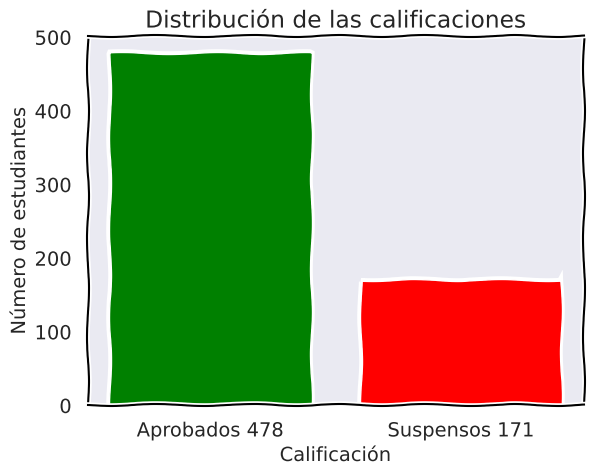

In [211]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Eliminamos las columnas 'school' por los motivos explicados
df = df.drop(['school'], axis=1)

# Calculamos la media de las columnas G1 y G2
df['Media_G1_G2'] = df[['G1', 'G2']].mean(axis=1)

# Aplicamos la función a la nueva columna para crear la columna de categorías
df['Calificacion'] = df['Media_G1_G2'].apply(asignar_categoria)

conteo_clases(df)

# Con esta función seleccionamos los atributos categóricos y los transformamos a codificación one-hot
categorical_columns = df.select_dtypes(include=['object']).columns
for i in categorical_columns:
    if len(df[i].unique()) == 2:
        # Si solo hay dos categorías, usar LabelEncoder
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    else:
        df_dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df.drop(i, axis=1), df_dummies],axis=1)
df['Media_G1_G2'] = df['Media_G1_G2'].astype(int)

#Pondremos los nombres de los atributos en una lista para poder visualizar mejor los datos que usaremos, eliminamos los targets porque no los usaremos para entrenar ni testear
Test_names = df.columns.tolist()
for column in ['G1', 'G2', 'Media_G1_G2', 'Calificacion']:
    Test_names.remove(column)

Observamos una gran parte de los datos son aprobados frente a unos pocos suspensos. Por lo que aplicaremos la técnica Random Under Sampling para tener un mejor balanceo de datos.

In [212]:
target_counts = df['Calificacion'].value_counts()

# Encuentra la clase minoritaria y mayoritaria
minority_class = target_counts.idxmin()
minority_count = target_counts.min()

majority_class = target_counts.idxmax()
majority_count = target_counts.max()

# Submuestreo de la clase mayoritaria
df_majority = df[df['Calificacion'] == majority_class]
df_minority = df[df['Calificacion'] == minority_class]

df_majority_under = df_majority.sample(minority_count)

# Concatena la clase minoritaria con la clase mayoritaria submuestreada
df_under = pd.concat([df_majority_under, df_minority], axis=0)

# Sobremuestreo de la clase minoritaria
df_minority_over = df_minority.sample(majority_count, replace=True)

# Concatena la clase mayoritaria con la clase minoritaria sobremuestreada
df_over = pd.concat([df_majority, df_minority_over], axis=0)

Creamos una lista con todos los datasets que tenemos 

In [213]:
# Supongamos que deseas utilizar las claves 'original', 'undersampled' y 'oversampled'
diccionario_datasets = {
    'original': df,
    'undersampled': df_under,
    'oversampled': df_over
}

Graficamos los datos

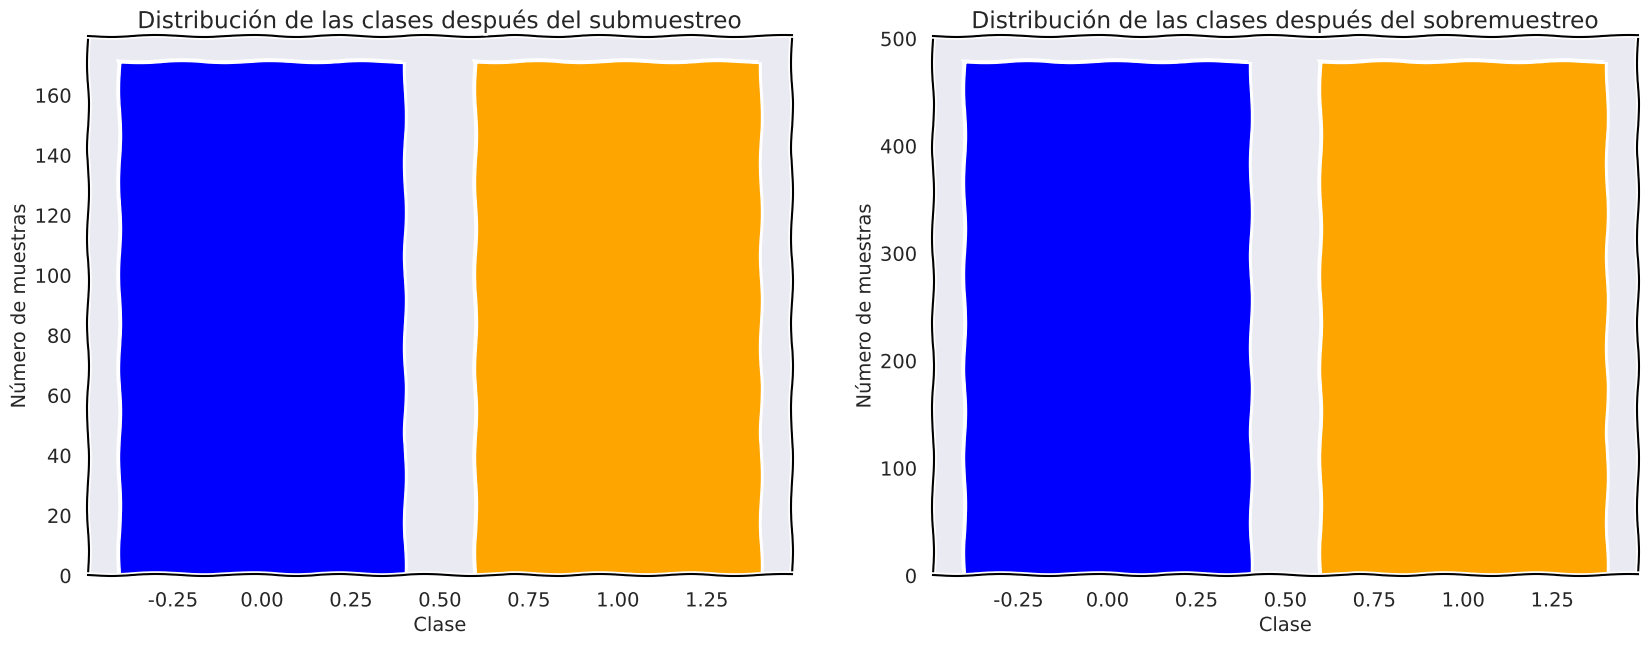

In [214]:
# Contar el número de muestras en cada clase después del submuestreo
under_counts = df_under['Calificacion'].value_counts()

# Contar el número de muestras en cada clase después del sobremuestreo
over_counts = df_over['Calificacion'].value_counts()

with plt.xkcd():
# Crear una figura con dos subgráficos
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    # Gráfico de barras para el submuestreo
    ax[0].bar(under_counts.index, under_counts.values, color=['blue', 'orange'])
    ax[0].set_title('Distribución de las clases después del submuestreo')
    ax[0].set_xlabel('Clase')
    ax[0].set_ylabel('Número de muestras')

    # Gráfico de barras para el sobremuestreo
    ax[1].bar(over_counts.index, over_counts.values, color=['blue', 'orange'])
    ax[1].set_title('Distribución de las clases después del sobremuestreo')
    ax[1].set_xlabel('Clase')
    ax[1].set_ylabel('Número de muestras')
    plt.show()

**df_under**: Este conjunto de datos se ha creado mediante el submuestreo de la clase mayoritaria para igualar el número de muestras de la clase minoritaria. Puedes usar este conjunto de datos si quieres dar igual importancia a todas las clases en tu modelo.

**df_over**: Este conjunto de datos se ha creado mediante el sobremuestreo de la clase minoritaria para igualar el número de muestras de la clase mayoritaria. Puedes usar este conjunto de datos si tu modelo tiene problemas para reconocer la clase minoritaria debido a su escasez de muestras.

Como queremos darle la misma importancia a ambos datos empleamos df_under a menos que se encuentren problemas en el modelo para reconocer los suspensos.

### Particionamiento del dataset en Train-Validation-Test
Particionamos los datos en train,validacion y test por cada atributo target que tenemos, en este caso son 3 'G1','G2' y 'Media_G1_G2'.

Se distingue entre atributos de entrada y de salida. Se usa como atributos de entrada todos a excepcion de los que usamos como salida, que son 'G1','G2','Media_G1_G2','Calificacion', que contiene los atrigutos target de nuestros modelos 'Calificacion' para los modelos de calsificacion y las notas y la media los modelos de prediccion).

In [215]:
# Hacemos un particionamiento estándar, 60% para train y 40% para test
train_data, temp_data = train_test_split(df_under, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Sacamos los atributos target
y_train_G1 = train_data['G1']
y_train_G2 = train_data['G2']
y_train_media = train_data['Media_G1_G2']


# Definimos X con el resto de atributos que no son los targets
X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

# Definimos los conjuntos de Test
y_test_G1 = test_data['G1']
y_test_G2 = test_data['G2']
y_test_media = test_data['Media_G1_G2']

# Sacamos los atributos de validacion
y_val_G1 = val_data['G1']
y_val_G2 = val_data['G2']
y_val_media = val_data['Media_G1_G2']

# Definimos X con el resto de atributos que no son los targets
X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


y_train_calificacion = train_data['Calificacion']
y_test_calificacion = test_data['Calificacion']
y_val_calificacion = val_data['Calificacion']

In [216]:
# Resumen estadístico de las variables de entrada del conjunto de entrenamiento
X_train.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.429268,16.887805,0.643902,0.297561,0.843902,2.346341,2.156098,1.663415,1.809756,0.073171,...,0.565854,0.287805,0.024390,0.482927,0.204878,0.146341,0.165854,0.170732,0.741463,0.087805
std,0.496183,1.257175,0.480017,0.458305,0.363836,1.116739,1.104813,0.809792,0.803120,0.261054,...,0.496858,0.453848,0.154635,0.500932,0.404601,0.354313,0.372860,0.377195,0.438902,0.283704
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,21.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [217]:
# Resumen estadístico de las variables de entrada del conjunto de entrenamiento
X_val.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.426471,16.941176,0.632353,0.264706,0.970588,2.367647,2.176471,1.750000,1.764706,0.132353,...,0.661765,0.264706,0.044118,0.441176,0.176471,0.176471,0.205882,0.264706,0.676471,0.058824
std,0.498241,1.314470,0.485750,0.444457,0.170214,1.183272,1.183735,0.903971,0.812544,0.341394,...,0.476627,0.444457,0.206883,0.500219,0.384054,0.384054,0.407351,0.444457,0.471301,0.237044
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.500000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [218]:
# Resumen estadístico de las variables de entrada del conjunto de entrenamiento
X_test.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.478261,16.869565,0.652174,0.231884,0.927536,2.347826,2.159420,1.478261,1.797101,0.115942,...,0.521739,0.304348,0.057971,0.565217,0.188406,0.086957,0.159420,0.246377,0.695652,0.057971
std,0.503187,1.235659,0.479770,0.425127,0.261154,1.148222,1.023592,0.677554,0.778001,0.322501,...,0.503187,0.463502,0.235401,0.499360,0.393901,0.283836,0.368749,0.434057,0.463502,0.235401
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,19.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


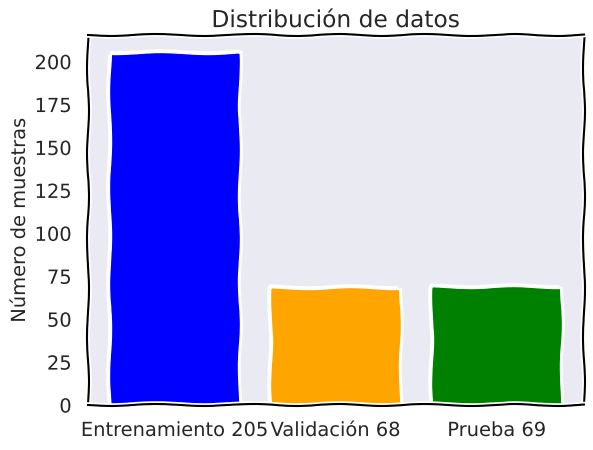

In [219]:
# Número de muestras en cada conjunto de datos
num_train = len(X_train)
num_val = len(X_val)
num_test = len(X_test)

# Etiquetas para el eje x
labels = [f'Entrenamiento {num_train}', f'Validación {num_val}', f'Prueba {num_test}']

# Valores (número de muestras)
values = [num_train, num_val, num_test]

with plt.xkcd():
    # Crear el histograma
    plt.bar(labels, values, color=['blue', 'orange', 'green'])

    # Añadir títulos y etiquetas
    plt.title('Distribución de datos')
    plt.ylabel('Número de muestras')

    # Mostrar el gráfico
    plt.show()

### Estandarizacion de datos

Los modelos asumen que todas las características están centradas alrededor de cero y tienen la misma varianza. Si una característica tiene una varianza que es órdenes de magnitud mayor que otras, podría dominar la función objetivo y hacer que el estimador no pueda aprender de otras características correctamente como se esperaba. La estandarización hace que los datos cumplan con estos supuestos y puede hacer que el algoritmo de aprendizaje sea más eficiente.

In [220]:
# Creamos el estandarizador
scaler = StandardScaler()

# Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Regresion Lineal

Al tener como target un atributo numerico nos parecía interesante probar un modelo de prediccion.

In [221]:
# Aplicamos el modelo de regresión lineal
modelo_lineal_G1 = LinearRegression()
modelo_lineal_G2 = LinearRegression()
modelo_lineal_media = LinearRegression()

# Entrenamos el modelo
modelo_lineal_G1.fit(X_train, y_train_G1)
modelo_lineal_G2.fit(X_train, y_train_G2)
modelo_lineal_media.fit(X_train, y_train_media)

# Generamos las predicciones del modelo para los datos de entrenamiento
y_train_pred_G1 = modelo_lineal_G1.predict(X_train)
y_train_pred_G2 = modelo_lineal_G2.predict(X_train)
y_train_pred_media = modelo_lineal_media.predict(X_train)

# Calculamos la salida del modelo
y_pred_G1 = modelo_lineal_G1.predict(X_test)
y_pred_G2 = modelo_lineal_G2.predict(X_test)
y_pred_media = modelo_lineal_media.predict(X_test)

# Medimos el error cuadrático medio del modelo
mse_G1 = mean_squared_error(y_test_G1, y_pred_G1)
mse_G2 = mean_squared_error(y_test_G2, y_pred_G2)
mse_media = mean_squared_error(y_test_media, y_pred_media)

print("MSE para G1 = ", round(mse_G1, 2))
print("MSE para G2 = ", round(mse_G2, 2))
print("MSE para Media = ", round(mse_media, 2))

MSE para G1 =  8.94
MSE para G2 =  11.39
MSE para Media =  9.28


Como vemos los valores de los MSE son muy altos, lo que indica que este no es un modelo adecuado para este problema ya que se aproxima poco a los resultados reales. Probaremos a usar polinomiales para ver si mejora su rendimiento.

# Regresion Lineal Polinomica (grado: 3)

A continuación probaremos con un modelo polinómico para comprobar si de esta manera conseguimos un mejor resultado.

In [222]:
# Creamos una instancia de LinearRegression
model_G1 = LinearRegression()
model_G2 = LinearRegression()
model_media = LinearRegression()

degree = 3

# Creamos una instancia de PolynomialFeatures para transformar nuestros datos a un espacio polinomial
poly = PolynomialFeatures(degree=degree)

# Transformamos nuestros datos de entrenamiento y de prueba
X_train_poly_G1 = poly.fit_transform(X_train)
X_test_poly_G1 = poly.transform(X_test)

X_train_poly_G2 = poly.fit_transform(X_train)
X_test_poly_G2 = poly.transform(X_test)

X_train_poly_media = poly.fit_transform(X_train)
X_test_poly_media = poly.transform(X_test)

# Entrenamos el modelo
model_G1.fit(X_train_poly_G1, y_train_G1)
model_G2.fit(X_train_poly_G2, y_train_G2)
model_media.fit(X_train_poly_media, y_train_media)

# Hacemos predicciones
y_pred_G1 = model_G1.predict(X_test_poly_G1)
y_pred_G2 = model_G2.predict(X_test_poly_G2)
y_pred_media = model_media.predict(X_test_poly_media)

# Medimos el error cuadrático medio del modelo
mse_G1 = mean_squared_error(y_test_G1, y_pred_G1)
mse_G2 = mean_squared_error(y_test_G2, y_pred_G2)
mse_media = mean_squared_error(y_test_media, y_pred_media)

print("MSE para G1 = ", round(mse_G1, 2))
print("MSE para G2 = ", round(mse_G2, 2))
print("MSE para Media = ", round(mse_media, 2))

MSE para G1 =  9.08
MSE para G2 =  11.25
MSE para Media =  9.2


### Graficamos los datos que hemos calculado

Veremos de manera gráfica los datos comparados con las predicciones y como nuestro modelo se ajusta a estos datos.

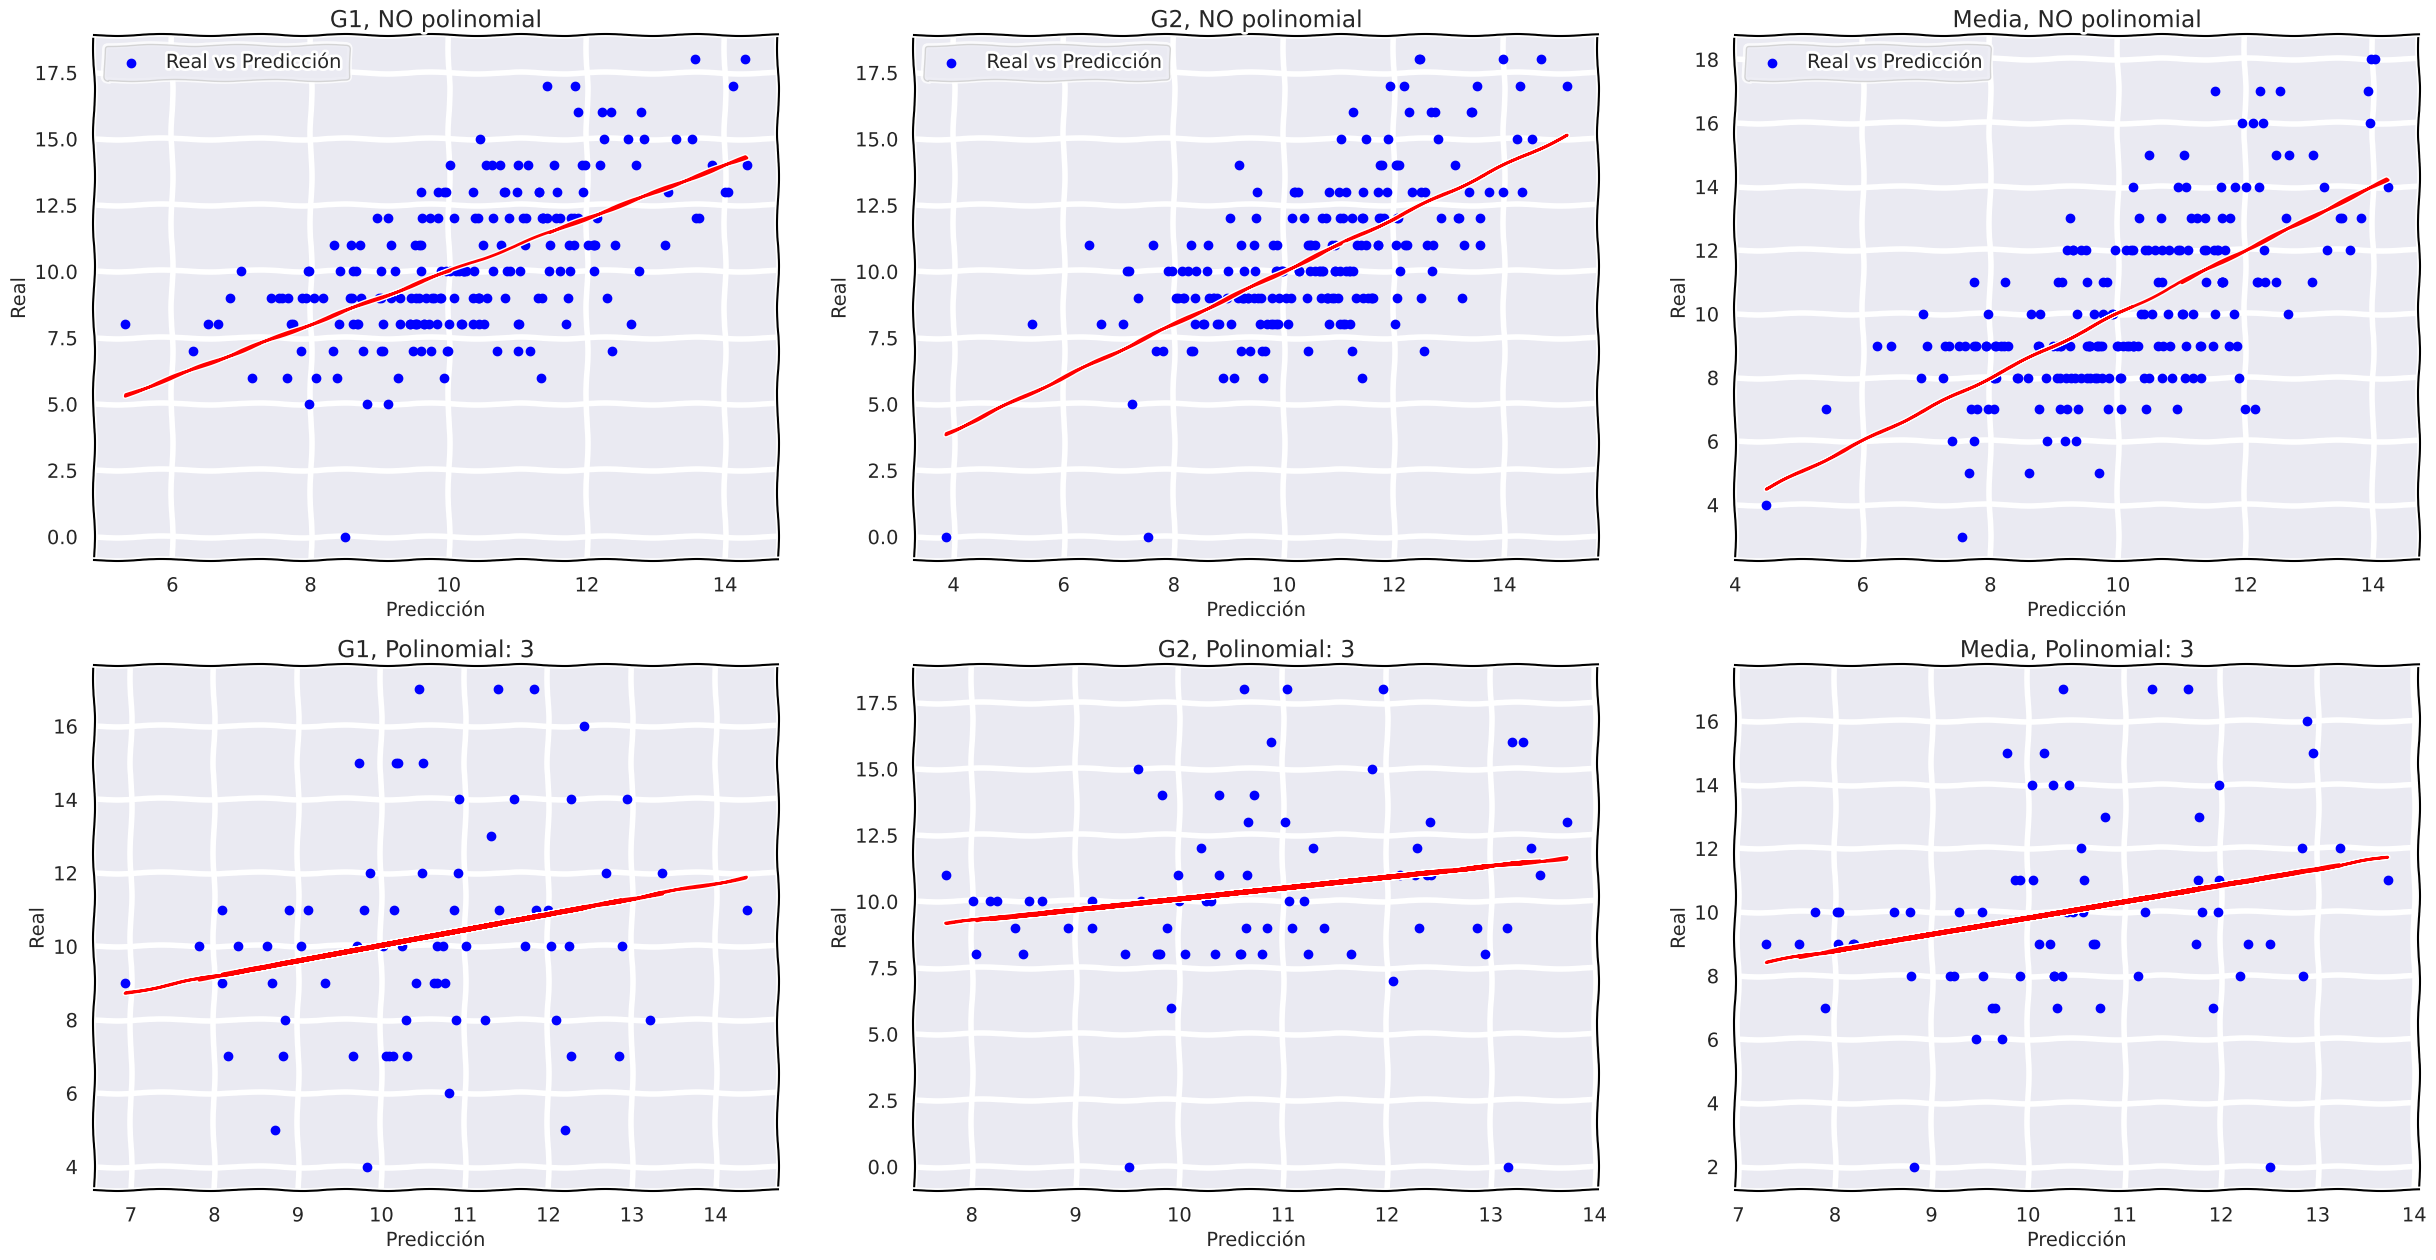

In [223]:
with plt.xkcd():
    # Creamos una figura y un conjunto de subtramas
    fig, ax = plt.subplots(2, 3, figsize=(30, 15))

    # Graficamos los datos reales y las predicciones del modelo para G1
    ax[0][0].scatter(y_train_pred_G1, y_train_G1, color='blue', label='Real vs Predicción')

    # Añadimos la línea de regresión lineal
    m, b = np.polyfit(y_train_pred_G1, y_train_G1, 1)
    ax[0][0].plot(y_train_pred_G1, m*y_train_pred_G1 + b, color='red')

    ax[0][0].set_title('G1, NO polinomial')
    ax[0][0].set_xlabel('Predicción')
    ax[0][0].set_ylabel('Real')
    ax[0][0].grid(True)
    ax[0][0].legend()

    # Graficamos los datos reales y las predicciones del modelo para G2
    ax[0][1].scatter(y_train_pred_G2, y_train_G2, color='blue', label='Real vs Predicción')

    # Añadimos la línea de regresión lineal
    m, b = np.polyfit(y_train_pred_G2, y_train_G2, 1)
    ax[0][1].plot(y_train_pred_G2, m*y_train_pred_G2 + b, color='red')

    ax[0][1].set_title('G2, NO polinomial')
    ax[0][1].set_xlabel('Predicción')
    ax[0][1].set_ylabel('Real')
    ax[0][1].grid(True)
    ax[0][1].legend()

    # Graficamos los datos reales y las predicciones del modelo para Media
    ax[0][2].scatter(y_train_pred_media, y_train_media, color='blue', label='Real vs Predicción')

    # Añadimos la línea de regresión lineal
    m, b = np.polyfit(y_train_pred_media, y_train_media, 1)
    ax[0][2].plot(y_train_pred_media, m*y_train_pred_media + b, color='red')

    ax[0][2].set_title('Media, NO polinomial')
    ax[0][2].set_xlabel('Predicción')
    ax[0][2].set_ylabel('Real')
    ax[0][2].grid(True)
    ax[0][2].legend()

    # Graficamos los datos reales y las predicciones del modelo para G1
    ax[1][0].scatter(y_pred_G1, y_test_G1, color='blue')

    # # Añadimos la línea de regresión lineal
    m, b = np.polyfit(y_pred_G1, y_test_G1, 1)
    ax[1][0].plot(y_pred_G1, m*y_pred_G1 + b, color='red')

    ax[1][0].set_title(f"G1, Polinomial: {degree}")
    ax[1][0].set_xlabel('Predicción')
    ax[1][0].set_ylabel('Real')
    ax[1][0].grid(True)

    # Graficamos los datos reales y las predicciones del modelo para G2
    ax[1][1].scatter(y_pred_G2, y_test_G2, color='blue')

    # # Añadimos la línea de regresión lineal
    m, b = np.polyfit(y_pred_G2, y_test_G2, 1)
    ax[1][1].plot(y_pred_G2, m*y_pred_G2 + b, color='red')

    ax[1][1].set_title(f"G2, Polinomial: {degree}")
    ax[1][1].set_xlabel('Predicción')
    ax[1][1].set_ylabel('Real')
    ax[1][1].grid(True)

    # Graficamos los datos reales y las predicciones del modelo para G2
    ax[1][2].scatter(y_pred_media, y_test_media, color='blue')

    #Añadimos la línea de regresión lineal
    m, b = np.polyfit(y_pred_media, y_test_media, 1)
    ax[1][2].plot(y_pred_media, m*y_pred_media + b, color='red')

    ax[1][2].set_title(f"Media, Polinomial: {degree}")
    ax[1][2].set_xlabel('Predicción')
    ax[1][2].set_ylabel('Real')
    ax[1][2].grid(True)
    plt.show()

### Conclusiones
Los modelos de regresión lineal y polinomial aplicados a los datos de los estudiantes muestran un MSE muy alto. Al aplicar las polinómicas en el modelo el resultado sigue siedo tan alto que comprenderemos que esta taréa no nos dará buenos resultados con estas técnicas, lo que indica que estos modelos no son adecuados para predecir las calificaciones de los estudiantes.

Esto sugiere que se necesitan enfoques más sofisticados, posiblemente incluyendo otros tipos de modelos o recopilación de más datos. Probaremos a intentar predecir si superan el curso o no, empleando modelos de clasificacion para esta tarea, comenzando por el mas sencillo, Regresion Logistica.

In [224]:
##PONER UNA RED PARA PREDICCION

In [225]:
def matriz_confusion(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Clase 0', 'Clase 1', 'Clase 2'],
    yticklabels=['Clase 0', 'Clase 1', 'Clase 2'])
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.title('Matriz de Confusión')
    plt.show()

# Regresion Logística

Una vez descartado los modelos de predicción probaremos el modelo mas simple que hemos estudiado de clasificacion, emplearemos como target el atributo que hemos creado para etiquetar los ejemplos 'Calificacion'.

Probaremos tambien distintas maneras de ejecutar este modelo que hemos investigado para encontrar la mejor comfiguración.

### Funcion comparativa de Pesos

In [226]:
def mostrarPesos(best_model_log):# Calcular la importancia de las características
    importance = np.abs(best_model_log.coef_[0])

    # Ordenar las características por importancia
    indices = np.argsort(importance)

    # Crear una lista de tuplas (importancia, característica)
    importances_features = [(importance[i], Test_names[i]) for i in indices]

    # Ordenar la lista de tuplas por importancia
    importances_features.sort(reverse=True)

    # Obtener las 10 características más importantes
    top_features = importances_features[:10]

    # Separar las importancias y los nombres de las características
    importances = [importance for importance, _ in top_features]
    features = [feature for _, feature in top_features]

    with plt.xkcd():
        # Crear una figura
        fig, ax = plt.subplots(figsize=(10, 5))

        # Crear un gráfico de barras horizontal
        bars = ax.barh(features, importances, color='skyblue')

        # Invertir el eje y para que las características más importantes aparezcan en la parte superior
        ax.invert_yaxis()

        # Configurar el título y las etiquetas de los ejes
        ax.set_title('Regresion Logística')
        ax.set_xlabel('Pesos')

        # Añadir la importancia al lado de cada barra
        for bar, importance in zip(bars, importances):
            ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {importance:.2f}', 
                    va='center', ha='left', color='black', fontsize=12)
        plt.show()

## REGRESION LOGISTICA PROVANDO TODOS LOS DATASETS

Mejores parámetros para dataset  original :  {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Precision validacion para dataset  original :  76.92307692307693 %
[[91  8]
 [22  9]]


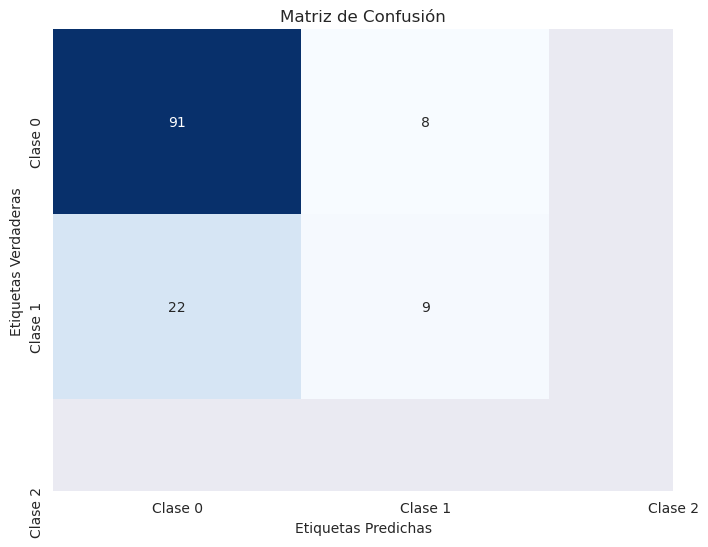

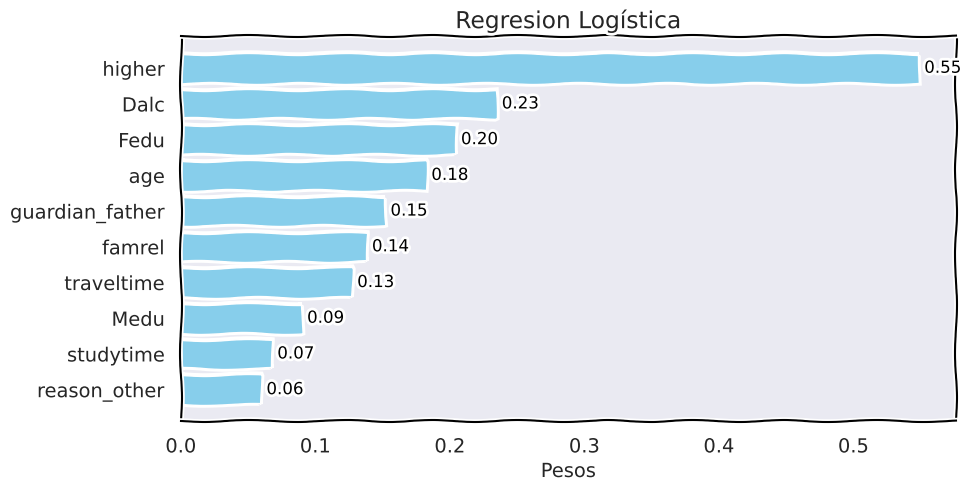

Mejores parámetros para dataset  undersampled :  {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Precision validacion para dataset  undersampled :  58.82352941176471 %
[[24 11]
 [17 16]]


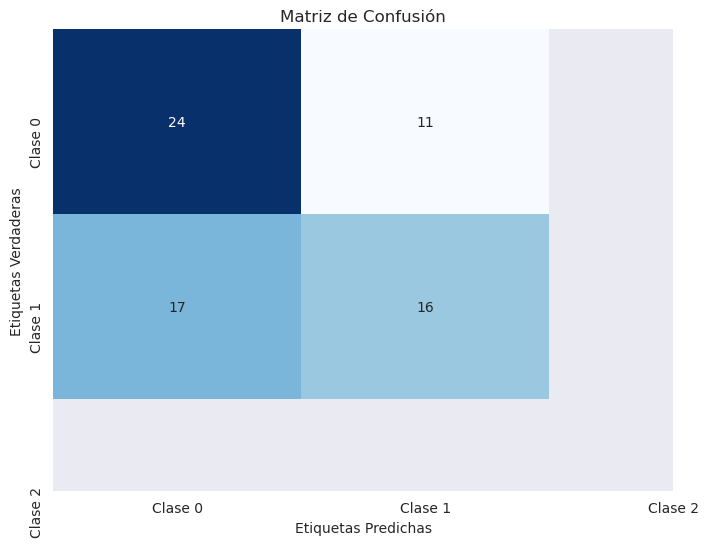

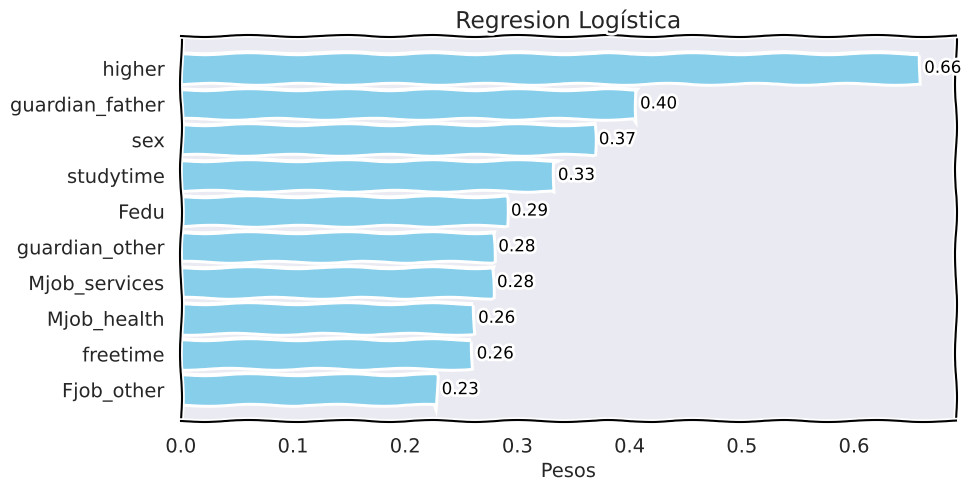

Mejores parámetros para dataset  oversampled :  {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Precision validacion para dataset  oversampled :  71.72774869109948 %
[[64 30]
 [24 73]]


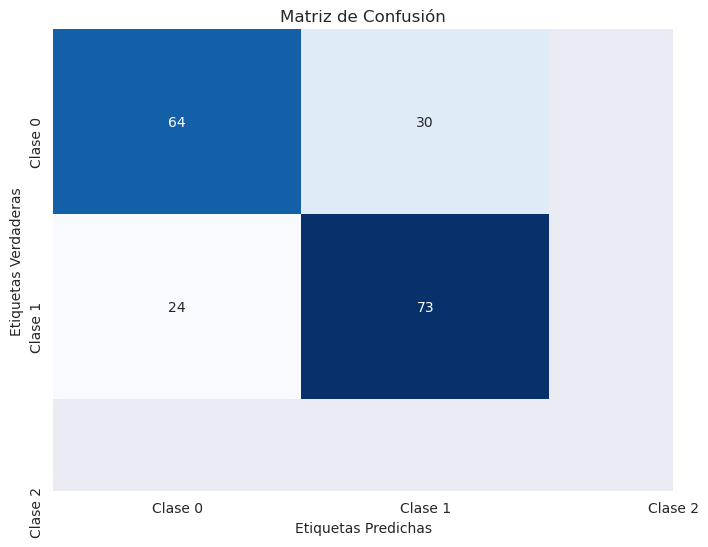

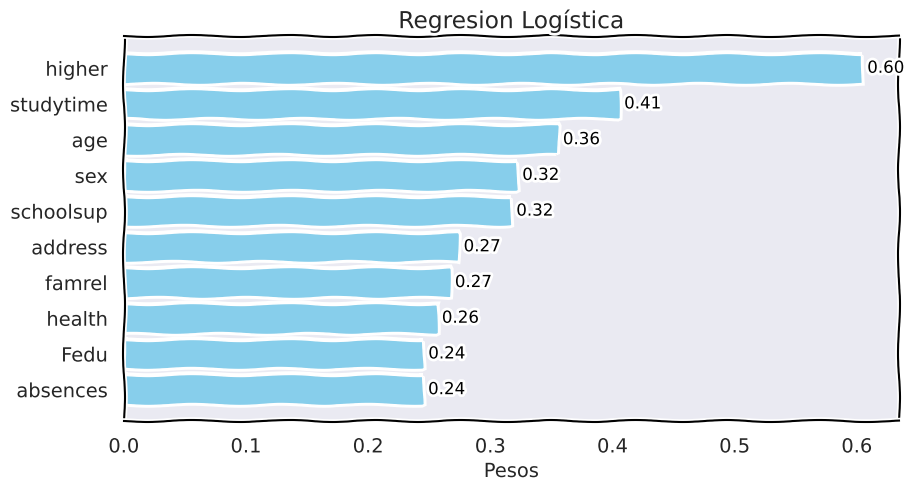

In [227]:
diccionario_log = {}
for i in diccionario_datasets: # Hacemos un particionamiento estándar, 60% para train y 40% para test
    train_data, temp_data = train_test_split(diccionario_datasets[i], test_size=0.4, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Sacamos los atributos target
    y_train_G1 = train_data['G1']
    y_train_G2 = train_data['G2']
    y_train_media = train_data['Media_G1_G2']


    # Definimos X con el resto de atributos que no son los targets
    X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

    # Definimos los conjuntos de Test
    y_test_G1 = test_data['G1']
    y_test_G2 = test_data['G2']
    y_test_media = test_data['Media_G1_G2']

    # Sacamos los atributos de validacion
    y_val_G1 = val_data['G1']
    y_val_G2 = val_data['G2']
    y_val_media = val_data['Media_G1_G2']

    # Definimos X con el resto de atributos que no son los targets
    X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
    X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


    y_train_calificacion = train_data['Calificacion']
    y_test_calificacion = test_data['Calificacion']
    y_val_calificacion = val_data['Calificacion']
    
    
    # Creamos el estandarizador
    scaler = StandardScaler()

    # Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    # Aplicamos el modelo de regresion logistica
    modelo_logistico_calificacion = LogisticRegression()


    #Definimos los parametros posibles de nuestro modelo
    param_grid = {'C': [0.1, 0.5, 1, 10],              
        'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
        'multi_class': ['ovr', 'multinomial'],
        'penalty': ['l1', 'l2']}

    grid_search_log = GridSearchCV(modelo_logistico_calificacion, param_grid, cv=5, scoring='accuracy')

    # Ejecutar la búsqueda en el conjunto de datos
    grid_search_log.fit(X_train, y_train_calificacion)

    # Obtener el mejor modelo y sus parámetros
    best_model_log = grid_search_log.best_estimator_
    best_params_log = grid_search_log.best_params_


    print("Mejores parámetros para dataset ", i, ": ", best_params_log)

    #Precision Validacion
    y_pred_val = best_model_log.predict(X_val)
    precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
    print("Precision validacion para dataset ", i, ": "  , 100 * precision_calificacion_val, "%")
    
    
    matriz_confusion(y_val_calificacion, y_pred_val)
    
    diccionario_log[i] = best_model_log
    
    mostrarPesos(best_model_log)

## REGRESION LOGISTICA NORMAL

Mejores parámetros: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Precision validacion:  71.72774869109948 %


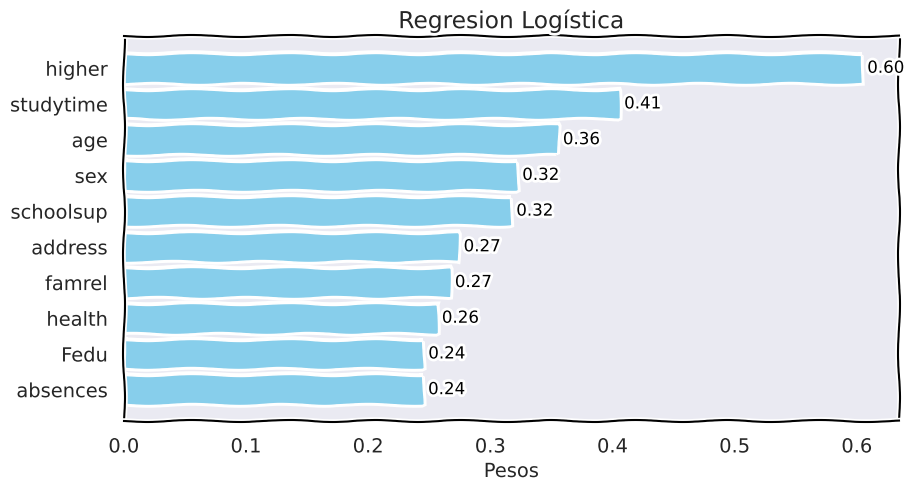

In [228]:
# Aplicamos el modelo de regresion logistica
modelo_logistico_calificacion = LogisticRegression()


#Definimos los parametros posibles de nuestro modelo
param_grid = {'C': [0.1, 0.5, 1, 10],              
    'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    'multi_class': ['ovr', 'multinomial'],
    'penalty': ['l1', 'l2']}

grid_search_log = GridSearchCV(modelo_logistico_calificacion, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_log.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_log = grid_search_log.best_estimator_
best_params_log = grid_search_log.best_params_


print("Mejores parámetros:", best_params_log)

#Precision Validacion
y_pred_val = best_model_log.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

mostrarPesos(best_model_log)

# Ensembles Adaboost

In [229]:
def grafica_precision(grid_search_adaboost):
    cv_results = grid_search_adaboost.cv_results_
    mean_test_scores = cv_results['mean_test_score']

    # Crear una lista con el número de estimadores
    n_estimators = list(range(1, 30))
    with plt.xkcd():
        plt.plot(n_estimators, mean_test_scores, marker='o')
        plt.title('Precisión en Entrenamiento K-Fold vs Número de Clasificadores')
        plt.xlabel('Número de Clasificadores')
        plt.ylabel('Precisión en Validación')
        plt.grid(True)
        plt.show()

# ENSEMBLES ADABOOST TODOS LOS DATASETS 

Mejores parámetros: original {'n_estimators': 3}
Precision validacion:  original 77.6923076923077 %
[[91  8]
 [21 10]]


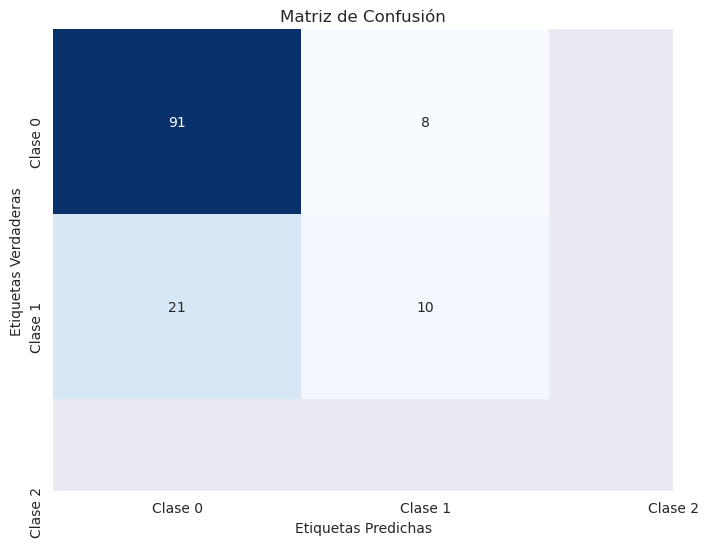

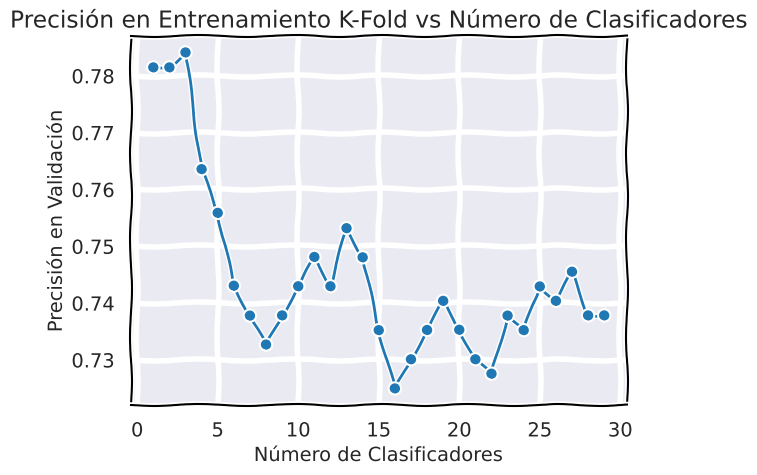

Mejores parámetros: undersampled {'n_estimators': 14}
Precision validacion:  undersampled 63.23529411764706 %
[[25 10]
 [15 18]]


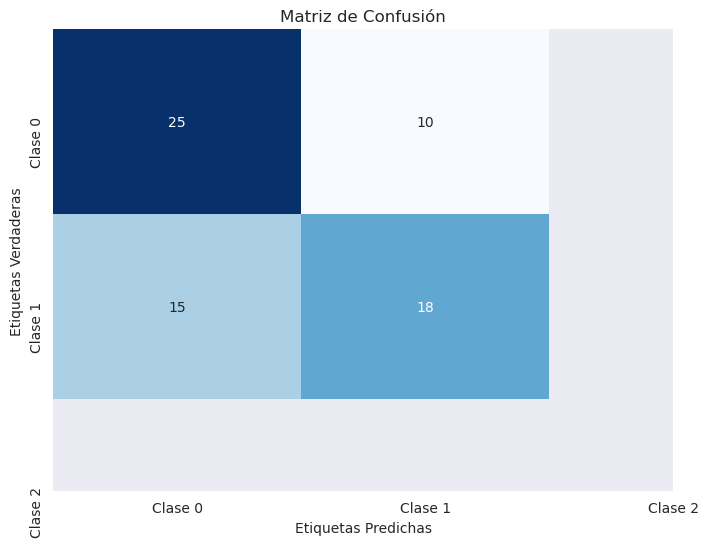

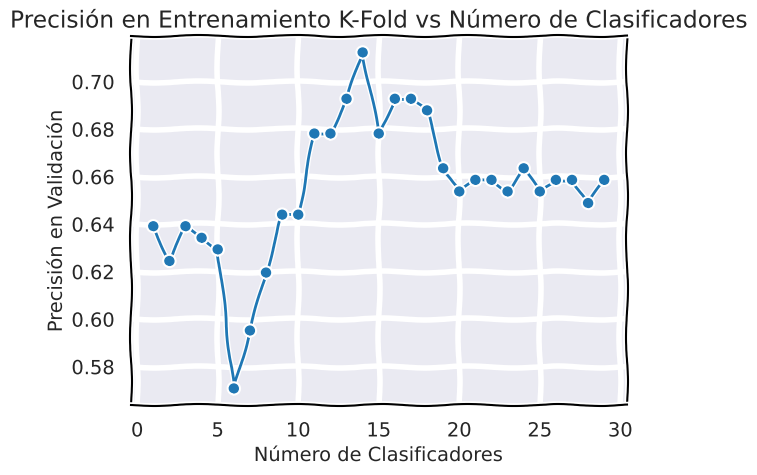

Mejores parámetros: oversampled {'n_estimators': 13}
Precision validacion:  oversampled 75.39267015706807 %
[[74 20]
 [27 70]]


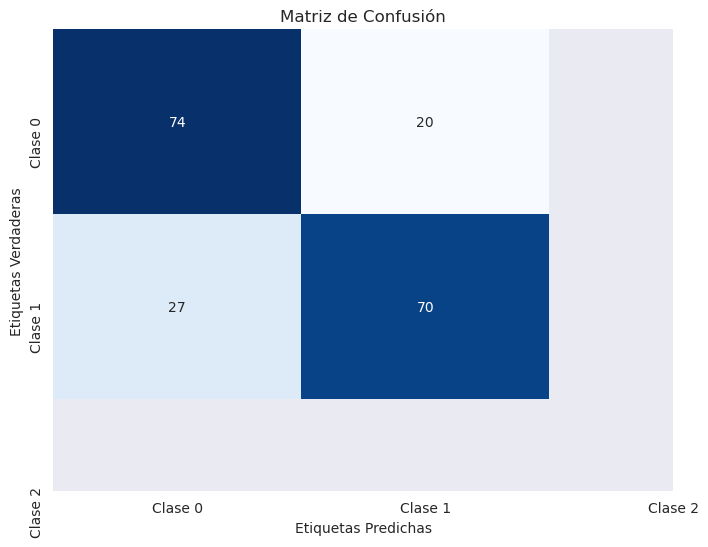

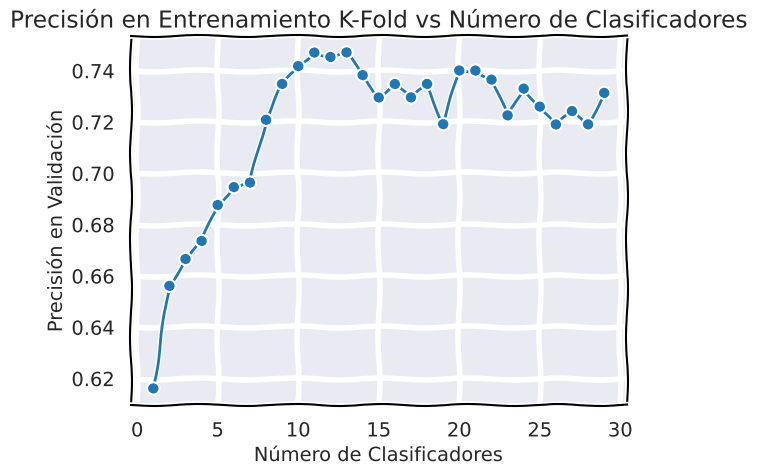

In [230]:
diccionario_adaboost = {}
for i in diccionario_datasets: # Hacemos un particionamiento estándar, 60% para train y 40% para test
    train_data, temp_data = train_test_split(diccionario_datasets[i], test_size=0.4, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Sacamos los atributos target
    y_train_G1 = train_data['G1']
    y_train_G2 = train_data['G2']
    y_train_media = train_data['Media_G1_G2']


    # Definimos X con el resto de atributos que no son los targets
    X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

    # Definimos los conjuntos de Test
    y_test_G1 = test_data['G1']
    y_test_G2 = test_data['G2']
    y_test_media = test_data['Media_G1_G2']

    # Sacamos los atributos de validacion
    y_val_G1 = val_data['G1']
    y_val_G2 = val_data['G2']
    y_val_media = val_data['Media_G1_G2']

    # Definimos X con el resto de atributos que no son los targets
    X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
    X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


    y_train_calificacion = train_data['Calificacion']
    y_test_calificacion = test_data['Calificacion']
    y_val_calificacion = val_data['Calificacion']
    
    
    # Creamos el estandarizador
    scaler = StandardScaler()

    # Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    
    #Defininos el clasificadores base
    clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

    param_grid = {'n_estimators': list(range(1, 30))}

    adaboost = AdaBoostClassifier(base_estimator=clasificador_base)
    grid_search_adaboost = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy',refit = True)

    # Ejecutar la búsqueda en el conjunto de datos
    grid_search_adaboost.fit(X_train, y_train_calificacion)

    # Obtener el mejor modelo y sus parámetros
    best_model_adaboost = grid_search_adaboost.best_estimator_
    best_params_adaboost = grid_search_adaboost.best_params_

    print("Mejores parámetros:", i, best_params_adaboost)

    #Precision Validacion
    y_pred_val = best_model_adaboost.predict(X_val)
    precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
    print("Precision validacion: ", i, 100 * precision_calificacion_val, "%")
    
    matriz_confusion(y_val_calificacion, y_pred_val)
    
    diccionario_adaboost[i] = best_model_adaboost
    
    grafica_precision(grid_search_adaboost)

# ENSEMBLES ADABOOST NORMAL

In [231]:
#Defininos el clasificadores base
clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

param_grid = {'n_estimators': list(range(1, 30))}

adaboost = AdaBoostClassifier(base_estimator=clasificador_base)
grid_search_adaboost = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy',refit = True)

# Ejecutar la búsqueda en el conjunto de datos
grid_search_adaboost.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_adaboost = grid_search_adaboost.best_estimator_
best_params_adaboost = grid_search_adaboost.best_params_

print("Mejores parámetros:", best_params_adaboost)

#Precision Validacion
y_pred_val = best_model_adaboost.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

Mejores parámetros: {'n_estimators': 13}
Precision validacion:  75.39267015706807 %


Vamos a graficar como evoluciona la precision en el proceso de entrenamiento (utilizando K-Fold) en funcion del numero de estimadores

### Red Neuronal

    1. 'lbfgs' es un optimizador de la familia de métodos quasi-Newton.
    2. 'sgd' se refiere al descenso de gradiente estocástico.
    3. 'adam' se refiere al optimizador estocástico propuesto por Kingma, Diederik, y Jimmy Ba.

## RED NEURONAL CON TODOS LOS DATASETS

Mejores parámetros: original {'solver': 'adam'}
Precision validacion:  original 72.3076923076923 %


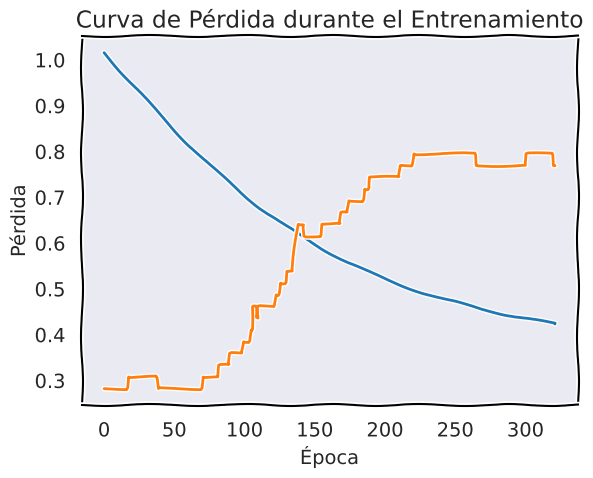

[[77 22]
 [14 17]]


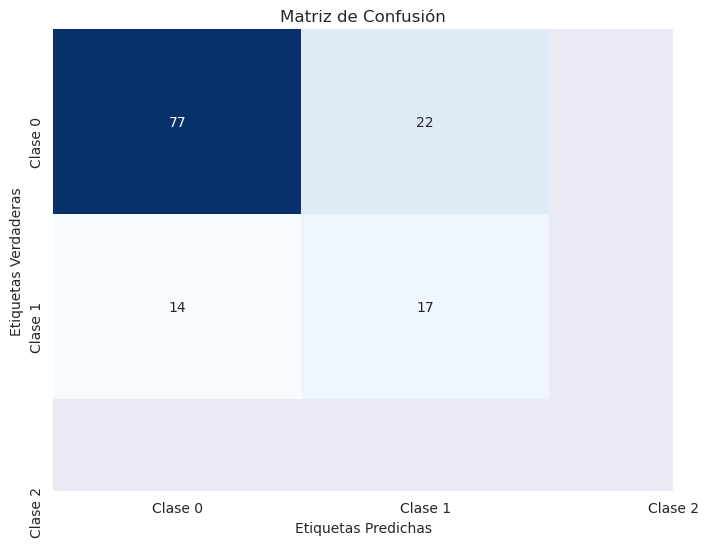

Mejores parámetros: undersampled {'solver': 'adam'}
Precision validacion:  undersampled 48.529411764705884 %


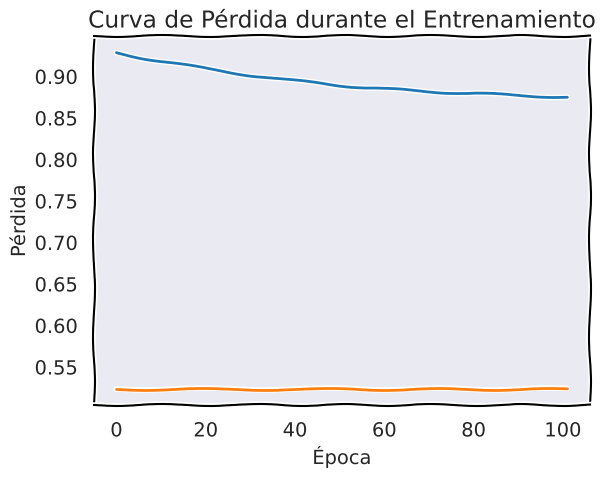

[[ 0 35]
 [ 0 33]]


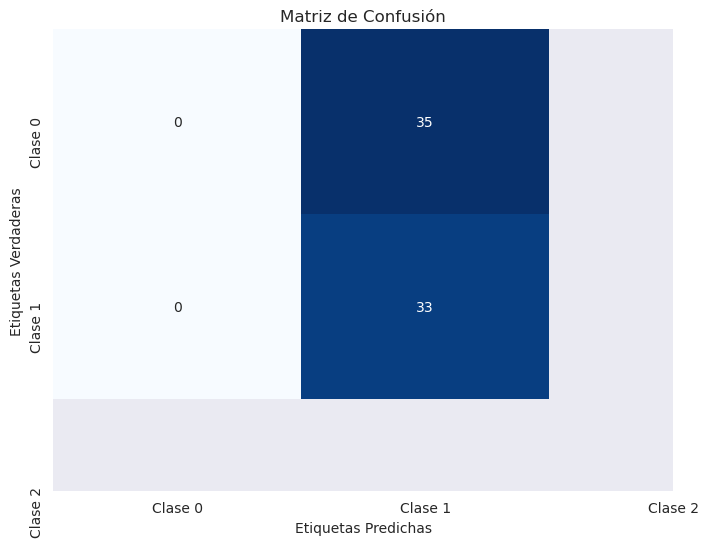

Mejores parámetros: oversampled {'solver': 'adam'}
Precision validacion:  oversampled 49.21465968586388 %


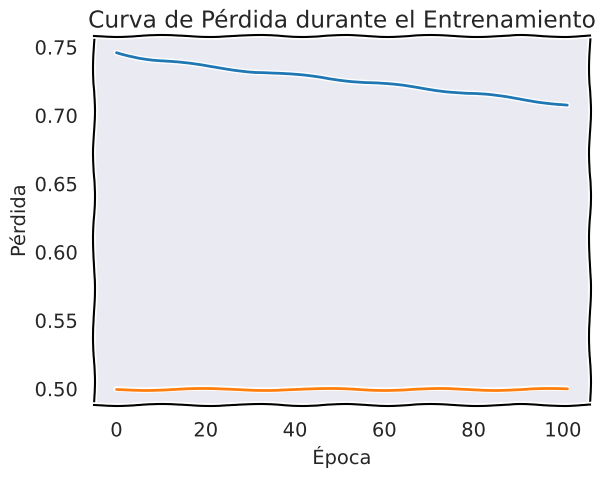

[[94  0]
 [97  0]]


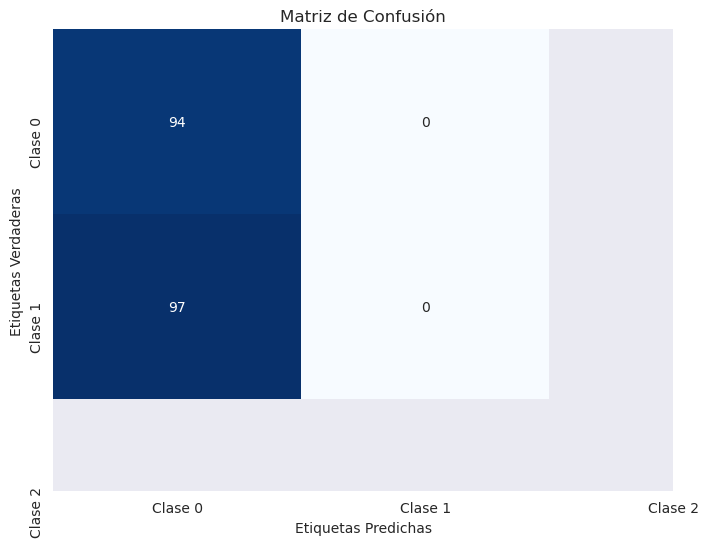

In [232]:
diccionario_red = {}
for i in diccionario_datasets: # Hacemos un particionamiento estándar, 60% para train y 40% para test
    train_data, temp_data = train_test_split(diccionario_datasets[i], test_size=0.4, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Sacamos los atributos target
    y_train_G1 = train_data['G1']
    y_train_G2 = train_data['G2']
    y_train_media = train_data['Media_G1_G2']


    # Definimos X con el resto de atributos que no son los targets
    X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

    # Definimos los conjuntos de Test
    y_test_G1 = test_data['G1']
    y_test_G2 = test_data['G2']
    y_test_media = test_data['Media_G1_G2']

    # Sacamos los atributos de validacion
    y_val_G1 = val_data['G1']
    y_val_G2 = val_data['G2']
    y_val_media = val_data['Media_G1_G2']

    # Definimos X con el resto de atributos que no son los targets
    X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
    X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


    y_train_calificacion = train_data['Calificacion']
    y_test_calificacion = test_data['Calificacion']
    y_val_calificacion = val_data['Calificacion']
    
    # Creamos el estandarizador
    scaler = StandardScaler()

    # Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    clasificador = MLPClassifier(hidden_layer_sizes=(2*len(X_train[0]), 2), max_iter=1000,early_stopping = True,n_iter_no_change = 100,learning_rate_init = 0.0001)

    param_grid = {'solver': ['adam']}

    grid_search_red = GridSearchCV(clasificador, param_grid, cv=5, scoring='accuracy', refit=True)

    # Ejecutar la búsqueda en el conjunto de datos
    grid_search_red.fit(X_train, y_train_calificacion)

    # Obtener el mejor modelo y sus parámetros
    best_model_red = grid_search_red.best_estimator_
    best_params_red = grid_search_red.best_params_

    print("Mejores parámetros:", i, best_params_red)

    y_pred_val = best_model_red.predict(X_val)
    precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
    print("Precision validacion: ", i, 100 * precision_calificacion_val, "%")

    if isinstance(best_model_red, MLPClassifier):
        with plt.xkcd():
            # Trazar la curva de pérdida
            plt.plot(best_model_red.loss_curve_)
            plt.plot(best_model_red.validation_scores_)
            plt.title('Curva de Pérdida durante el Entrenamiento')
            plt.xlabel('Época')
            plt.ylabel('Pérdida')
            plt.show()
    else:
        print("El mejor modelo no es un MLPClassifier y no tiene una curva de pérdida.")
        
        
    diccionario_red[i] = best_model_red
        
    matriz_confusion(y_val_calificacion, y_pred_val)
    

## RED NEURONAL NORMAL

Mejores parámetros: {'solver': 'adam'}
Precision validacion:  77.4869109947644 %


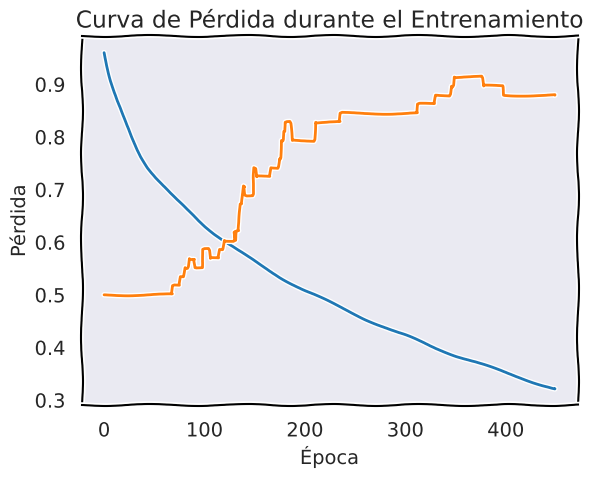

In [233]:
clasificador = MLPClassifier(hidden_layer_sizes=(2*len(X_train[0]), 2), max_iter=1000,early_stopping = True,n_iter_no_change = 100,learning_rate_init = 0.0001)

param_grid = {'solver': ['adam']}

grid_search_red = GridSearchCV(clasificador, param_grid, cv=5, scoring='accuracy', refit=True)

# Ejecutar la búsqueda en el conjunto de datos
grid_search_red.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_red = grid_search_red.best_estimator_
best_params_red = grid_search_red.best_params_

print("Mejores parámetros:", best_params_red)

y_pred_val = best_model_red.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

if isinstance(best_model_red, MLPClassifier):
    with plt.xkcd():
        # Trazar la curva de pérdida
        plt.plot(best_model_red.loss_curve_)
        plt.plot(best_model_red.validation_scores_)
        plt.title('Curva de Pérdida durante el Entrenamiento')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.show()
else:
    print("El mejor modelo no es un MLPClassifier y no tiene una curva de pérdida.")

## Comparacion de los modelos

# Comparacion modelos multiples datasets

                Nombre  Precisión
0             Adaboost      75.39
1         Red Neuronal      77.49
2  Regresion Logistica      71.73

El modelo con mayor validacion es:  ('Red Neuronal', 0.774869109947644)


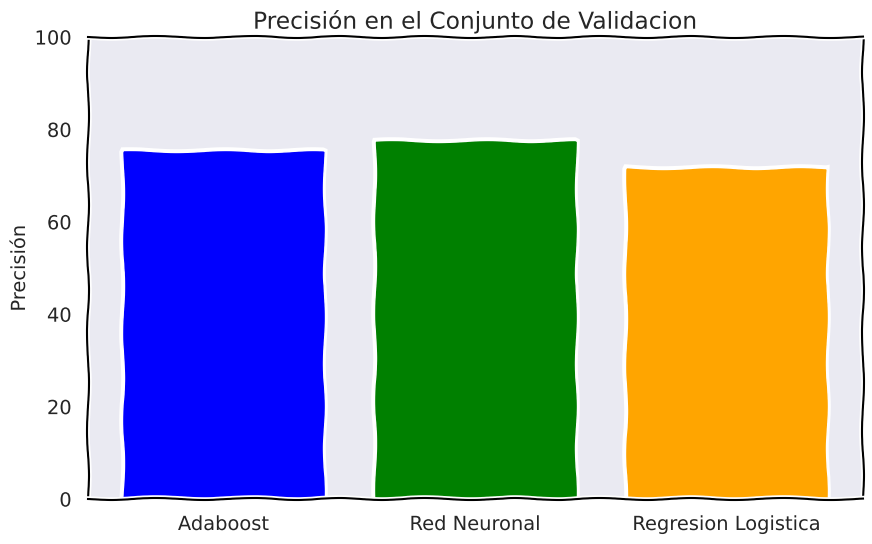

In [234]:
clasificadores_entrenados = [best_model_adaboost, best_model_red, best_model_log]

nombres = ['Adaboost', 'Red Neuronal', 'Regresion Logistica']

# Inicializar precisiones
ganador = (0, 0)
bestPres = 0
precision_val = []
resultados = []

for i, clasificador in enumerate(clasificadores_entrenados):
    # Iteramos en la lista clasificadores y miramos la precisión de cada uno en validación
    y_pred_val = clasificador.predict(X_val)
    accVal = accuracy_score(y_val_calificacion, y_pred_val)
    precision_val.append(100 * accVal)
    
    # Añadimos los resultados a la lista
    resultados.append([nombres[i], round(accVal*100,2)])
    
    # Guardamos la validación máxima
    if (accVal > bestPres):
        bestPres = accVal
        ganador = (nombres[i], accVal)
        mejor_clasificador = clasificador

# Convertimos la lista de resultados en un DataFrame, para verlo mas claramente con pandas
df_resultados = pd.DataFrame(resultados, columns=['Nombre', 'Precisión'])
print(df_resultados)

print("\nEl modelo con mayor validacion es: ", ganador)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.bar(nombres, precision_val, color=['blue', 'green', 'orange'])
    plt.title('Precisión en el Conjunto de Validacion')
    plt.ylabel('Precisión')
    plt.ylim(0, 100)
    plt.show()

Calculamos la precision en test del mejor modelo entrenado

In [235]:
precision_test = []
y_pred_test = mejor_clasificador.predict(X_test)
accTest = accuracy_score(y_test_calificacion, y_pred_test)
print("La prediccion final es: ", round(accTest*100,2))

La prediccion final es:  79.69


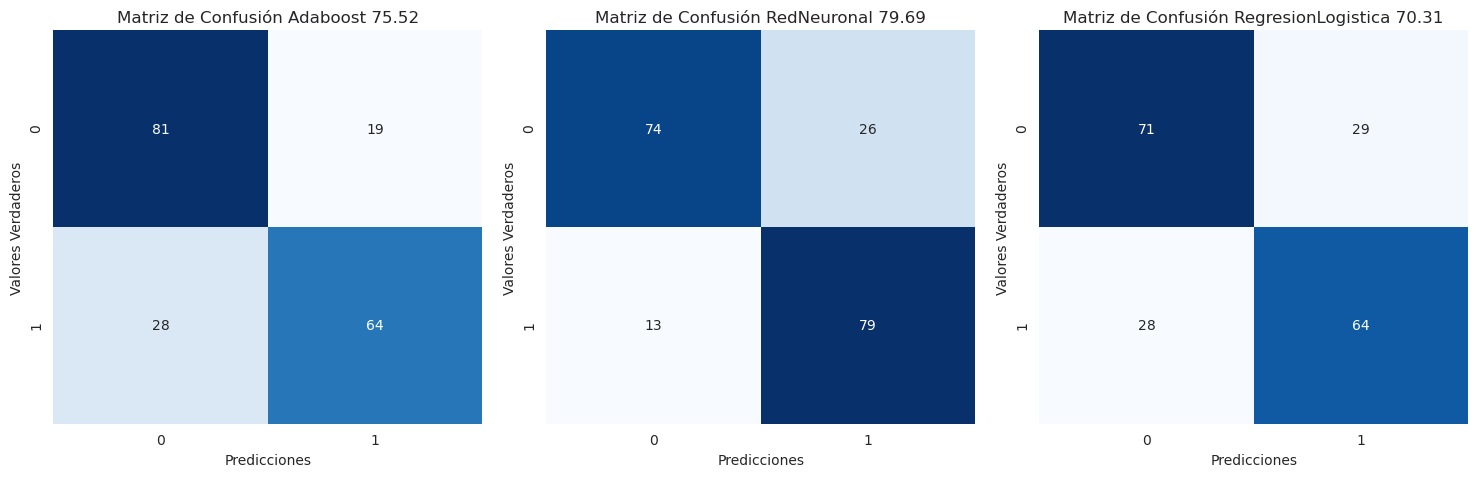

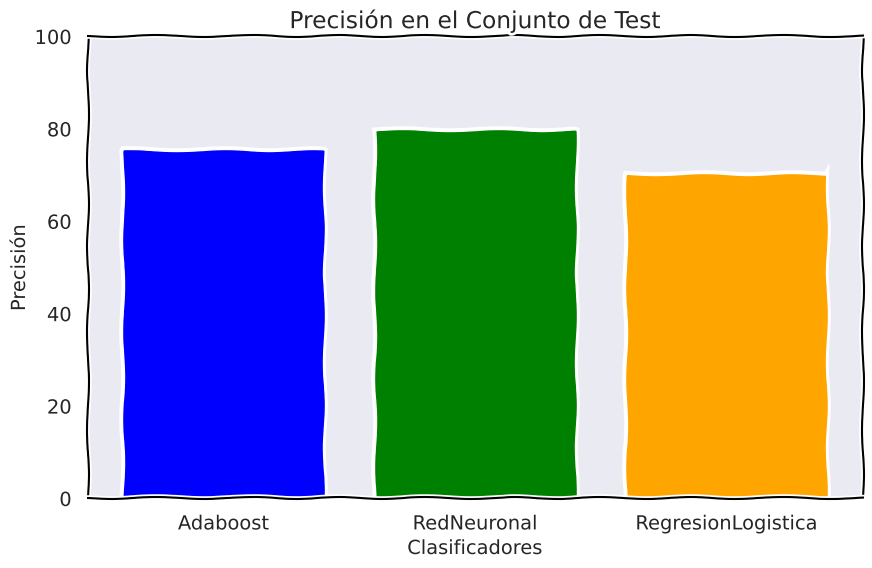

In [236]:
import seaborn as sns
nombres = ['Adaboost', 'RedNeuronal', 'RegresionLogistica']

# Inicializar parametros
ganador = (0, 0)
bestPres = 0
precision_test = []


# Crear una figura con varios subgráficos
fig, axs = plt.subplots(1, len(clasificadores_entrenados), figsize=(15, 5))

for i, clasificador in enumerate(clasificadores_entrenados):
    # Iteramos en la lista clasificadores y miramos la precision de cada uno en validacion
    y_pred_test = clasificador.predict(X_test)
    accTest = accuracy_score(y_test_calificacion, y_pred_test)
    precision_test.append(100 * accTest)
    matriz_confusion = confusion_matrix(y_test_calificacion, y_pred_test)

    # Imprime la matriz de confusión en el subgráfico correspondiente
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test_calificacion), yticklabels=np.unique(y_test_calificacion), ax=axs[i])


    # Configuraciones adicionales para mejorar la visualización
    axs[i].set_title('Matriz de Confusión ' + nombres[i] + f' {round(accTest*100,2)}')
    axs[i].set_xlabel('Predicciones')
    axs[i].set_ylabel('Valores Verdaderos')
    
    # Guardamos la validacion maxima
    if (accTest > bestPres):
        bestPres = accTest
        ganador = (nombres[i], accTest)
        mejor_clasificador = clasificador
        
with plt.xkcd():    
    plt.tight_layout()
    plt.figure(figsize=(10, 6))
    plt.bar(nombres, precision_test, color=['blue', 'green', 'orange'])
    plt.title('Precisión en el Conjunto de Test')
    plt.xlabel('Clasificadores')
    plt.ylabel('Precisión')
    plt.ylim(0, 100)
    plt.show()

# K-Means

Como nuestros ejemplos los hemos etiquetado nosotros, creemos que seria interesante probar un modelo de clustering ya que el dataset original no tiene los datos etiquetados y estudiar los clusters resultantes.

Comprobaremos mediante DB estudiado en clase el mejor numero de clusters.

El número óptimo de clústeres es 2


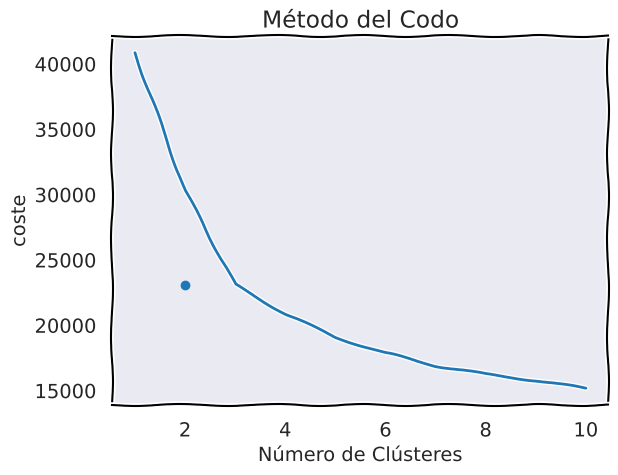

In [237]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


#df_muestra = df[['Calificacion', 'Media_G1_G2', 'G1', 'G2']]
#df = df.drop(['Calificacion', 'Media_G1_G2', 'G1', 'G2'], axis=1)


# Determinar el número óptimo de clústeres utilizando el método del codo
coste = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    coste.append(kmeans.inertia_)

with plt.xkcd(): 
    # Graficar el método del codo
    plt.plot(range(1, 11), coste)
    plt.title('Método del Codo')
    plt.xlabel('Número de Clústeres')
    plt.ylabel('coste')  # Within-Cluster-Sum-of-Squares

    # Elegir el número óptimo de clústeres basado en el gráfico del codo
    # En este caso, observa el punto donde la disminución en WCSS se desacelera significativamente
    # y selecciona ese número como el número óptimo de clústeres

    # Aplicar K-means con el número óptimo de clústeres
    # Calcular la primera y segunda derivada de los costes
    first_derivative = np.diff(coste)
    second_derivative = np.diff(coste,3)

    # El número óptimo de clústeres es donde la segunda derivada es la más grande (el "codo")
    optimal_clusters = np.argmax(second_derivative) + 2  # +2 porque el índice comienza en 0 y estamos usando la segunda derivada
    print(f"El número óptimo de clústeres es {optimal_clusters}")

    plt.scatter(optimal_clusters,coste [optimal_clusters])
    plt.show()    
    
#numero de ejemplos en cada cluster
#mostrar la moda de cada columna para cada cluster
#seaborn